In [1]:
import geopandas as gpd
import pandas as pd

/Users/thomas/.pyenv/versions/3.9.12/envs/gds/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_1446/1565847299.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sh

We want to see how many unique routes there are in the dataset, as well as in part of the data we enriched with routes-data. 

In [11]:
bike_data = pd.read_csv("../data/july_2022_filtered_renamed.csv")
bike_data = bike_data.drop(columns=["Unnamed: 0"])
print(bike_data.shape)

(131704, 15)


In [12]:
gdf = gpd.read_file("../data/data_all_gpd_v3.shp")
print(gdf.shape)
gdf.head(5)

(67890, 19)


,started_at,ended_at,duration,st_st_id,st_st_name,st_st_desc,st_st_lat,st_st_lon,en_st_id,en_st_name,en_st_desc,en_st_lat,en_st_lon,minutes,id,total_dist,waytypes_d,waytypes_s,geometry
0,2022-07-02 08:39:02.618000+00:00,2022-07-02 08:47:54.958000+00:00,532,408,Tøyen skole,forsiden av skolebygget,59.914943,10.773977,448,Oslo Plaza,ved rundkjøringen,59.912183,10.754434,8,6044,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
1,2022-07-02 08:39:04.505000+00:00,2022-07-02 08:48:36.381000+00:00,571,397,Storo Storsenter,langs Vitaminveien,59.946710,10.773805,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,9,6045,2701.3,0 2 7;2 86 2;86 94 7;94 111 6;111 112 7;112 11...,v:2.0 d:1435.3 a:53.14;v:3.0 d:805.4 a:29.82;v...,"LINESTRING (10.77378 59.94668, 10.77369 59.946..."
2,2022-07-02 08:39:22.379000+00:00,2022-07-02 08:55:10.095000+00:00,947,601,Rolf Wickstrøms vei,ved Bergrådveien,59.953411,10.757724,2309,Ulven Torg,"innenfor byggegjerdene, sør for Ulvenveien",59.924721,10.810727,15,6047,5583.8,0 4 7;4 83 6;83 93 7;93 141 6;141 142 7;142 16...,v:6.0 d:2775.3 a:49.7;v:3.0 d:1226.1 a:21.96;v...,"LINESTRING (10.75776 59.95342, 10.75783 59.953..."
3,2022-07-02 08:40:20.905000+00:00,2022-07-02 09:03:56.044000+00:00,1415,464,Sukkerbiten,ved gangbroen,59.905124,10.753764,561,Kirkeveien,ved Gørbitz' gate,59.933480,10.726294,23,6052,4430.6,0 3 7;3 7 4;7 8 7;8 18 2;18 42 1;42 139 2;139 ...,v:2.0 d:2641.3 a:59.61;v:3.0 d:841.5 a:18.99;v...,"LINESTRING (10.75380 59.90512, 10.75386 59.905..."
4,2022-07-02 08:40:45.470000+00:00,2022-07-02 08:50:08.635000+00:00,563,519,Thomas Heftyes plass,ved Bygdøy allé,59.918578,10.703900,473,Majorstuveien,langs Maries gate,59.926697,10.716195,9,6053,1409.8,0 3 7;3 30 2;30 54 1;54 64 3;,v:1.0 d:657.1 a:46.61;v:2.0 d:427.4 a:30.32;v:...,"LINESTRING (10.70389 59.91857, 10.70347 59.918..."


In [13]:
# Get a list of unique routes (start and stop stations).

routes_list_sorted = []
routes_list = []

for row in gdf[['st_st_id', 'en_st_id']].iterrows():
    route = list(row[1])

    if route not in routes_list:
        routes_list.append(route)

    route_sort = route
    route_sort.sort()

    if route not in routes_list_sorted:
        routes_list_sorted.append(route)

print('ENRICHED DATA')
print(f'Routes when the order of start and stop is important: {len(routes_list)}')
print(f'Routes when the order of start and stop is NOT important: {len(routes_list_sorted)}')

ENRICHED DATA
Routes when the order of start and stop is important: 42241
Routes when the order of start and stop is NOT important: 18382


In [14]:
for idxA, routeA in enumerate(gdf[['st_st_id', 'en_st_id']].iterrows()):
    routeA = list(routeA[1])

    for idxB, routeB in enumerate(gdf[['st_st_id', 'en_st_id']].iterrows()):
        routeB = list(routeB[1])

        routeB_rev = [routeB[1], routeB[0]]

        #print(routeA, routeB_rev)
        if routeA == routeB_rev:
            print(idxA, idxB, routeA, routeB)
            break
    if routeA == routeB_rev:
        break

0 8174 [408, 448] [448, 408]


In [15]:
print("Check two between the same stations from different directions.")
display(gdf[['st_st_id', 'st_st_name', 'en_st_id', 'en_st_name', 'minutes', 'id', 'total_dist']].iloc[[0, 8174]])
print('We can see there is a difference in the distance and time between the two routes.')

Check two between the same stations from different directions.


,st_st_id,st_st_name,en_st_id,en_st_name,minutes,id,total_dist
0,408,Tøyen skole,448,Oslo Plaza,8,6044,1502.2
8174,448,Oslo Plaza,408,Tøyen skole,9,5210,1510.2


We can see there is a difference in the distance and time between the two routes.


In [16]:
# Get a list of unique routes (start and stop stations).

bd_routes_list_sorted = []
bd_routes_list = []

for row in bike_data[['st_st_id', 'en_st_id']].iterrows():
    route = list(row[1])

    if route not in bd_routes_list:
        bd_routes_list.append(route)

    route_sort = route
    route_sort.sort()

    if route not in bd_routes_list_sorted:
        bd_routes_list_sorted.append(route)

print(f'Routes when the order of start and stop is important: {len(bd_routes_list)}')
print(f'Routes when the order of start and stop is NOT important: {len(bd_routes_list_sorted)}')

Routes when the order of start and stop is important: 74644
Routes when the order of start and stop is NOT important: 23349


In [17]:
gdf.shape

(67890, 19)

In [18]:
bike_data.shape

(131704, 15)

In [19]:
bike_data.head(5)

,started_at,ended_at,duration,st_st_id,st_st_name,st_st_desc,st_st_lat,st_st_lon,en_st_id,en_st_name,en_st_desc,en_st_lat,en_st_lon,minutes,id
0,2022-07-01 03:00:14.428000+00:00,2022-07-01 03:16:28.492000+00:00,974,447,Kværnerbyen,langs Smeltedigelen,59.904473,10.786167,1755,Aker Brygge,ved trikkestopp,59.911184,10.730035,16,0
1,2022-07-01 03:00:25.577000+00:00,2022-07-01 03:16:23.183000+00:00,957,537,St. Olavs gate,ved Pilestredet,59.917968,10.738629,431,Chr. Michelsens Gate,ved Fjellgata,59.927292,10.773185,15,1
2,2022-07-01 03:04:57.874000+00:00,2022-07-01 03:14:42.301000+00:00,584,563,Huitfeldts gate,ved Observatoriegata,59.912684,10.722900,2328,The Hub,Mellom Oslo City og The Hub hotel,59.912522,10.750910,9,6
3,2022-07-01 03:05:27.456000+00:00,2022-07-01 03:11:22.103000+00:00,354,442,Vulkan,ved Maridalsveien,59.922510,10.751010,599,Paléhaven,langs Strandgata,59.910331,10.750110,5,7
4,2022-07-01 03:11:37.601000+00:00,2022-07-01 03:47:45.110000+00:00,2167,464,Sukkerbiten,ved gangbroen,59.905124,10.753764,600,Dyvekes bru,ved skatepark,59.905323,10.768958,36,8


In [20]:
gdf.head(5)

,started_at,ended_at,duration,st_st_id,st_st_name,st_st_desc,st_st_lat,st_st_lon,en_st_id,en_st_name,en_st_desc,en_st_lat,en_st_lon,minutes,id,total_dist,waytypes_d,waytypes_s,geometry
0,2022-07-02 08:39:02.618000+00:00,2022-07-02 08:47:54.958000+00:00,532,408,Tøyen skole,forsiden av skolebygget,59.914943,10.773977,448,Oslo Plaza,ved rundkjøringen,59.912183,10.754434,8,6044,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
1,2022-07-02 08:39:04.505000+00:00,2022-07-02 08:48:36.381000+00:00,571,397,Storo Storsenter,langs Vitaminveien,59.946710,10.773805,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,9,6045,2701.3,0 2 7;2 86 2;86 94 7;94 111 6;111 112 7;112 11...,v:2.0 d:1435.3 a:53.14;v:3.0 d:805.4 a:29.82;v...,"LINESTRING (10.77378 59.94668, 10.77369 59.946..."
2,2022-07-02 08:39:22.379000+00:00,2022-07-02 08:55:10.095000+00:00,947,601,Rolf Wickstrøms vei,ved Bergrådveien,59.953411,10.757724,2309,Ulven Torg,"innenfor byggegjerdene, sør for Ulvenveien",59.924721,10.810727,15,6047,5583.8,0 4 7;4 83 6;83 93 7;93 141 6;141 142 7;142 16...,v:6.0 d:2775.3 a:49.7;v:3.0 d:1226.1 a:21.96;v...,"LINESTRING (10.75776 59.95342, 10.75783 59.953..."
3,2022-07-02 08:40:20.905000+00:00,2022-07-02 09:03:56.044000+00:00,1415,464,Sukkerbiten,ved gangbroen,59.905124,10.753764,561,Kirkeveien,ved Gørbitz' gate,59.933480,10.726294,23,6052,4430.6,0 3 7;3 7 4;7 8 7;8 18 2;18 42 1;42 139 2;139 ...,v:2.0 d:2641.3 a:59.61;v:3.0 d:841.5 a:18.99;v...,"LINESTRING (10.75380 59.90512, 10.75386 59.905..."
4,2022-07-02 08:40:45.470000+00:00,2022-07-02 08:50:08.635000+00:00,563,519,Thomas Heftyes plass,ved Bygdøy allé,59.918578,10.703900,473,Majorstuveien,langs Maries gate,59.926697,10.716195,9,6053,1409.8,0 3 7;3 30 2;30 54 1;54 64 3;,v:1.0 d:657.1 a:46.61;v:2.0 d:427.4 a:30.32;v:...,"LINESTRING (10.70389 59.91857, 10.70347 59.918..."


## Enrich the bike data we didnt have time to get

We tried to download all routes by going through all rentals taking place. However if we just looked at unique routes by start and stop points, we could have reduced the required data needed to be downloaded.

Now we want to find all unique routes in the downloaded data and add it to the list of unique routes in bike_data. 

In [70]:
routes_gdf = gdf[['st_st_id', 'en_st_id', 'total_dist', 'waytypes_d', 'waytypes_s', 'geometry']].copy()

# As we used the API at different times to get route data, it probably suggested different routes.
# Therefore we have more than one route between two stations. 
# Our assumption is that people took the same route between two stations, therefore we will drop duplicates.
routes_gdf.drop_duplicates(subset = ['st_st_id', 'en_st_id'], keep = 'first', inplace = True)

# Reset the index.
routes_gdf.reset_index(drop=True, inplace=True)

# Let see the result.
routes_gdf

,st_st_id,en_st_id,total_dist,waytypes_d,waytypes_s,geometry
0,408,448,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
1,397,421,2701.3,0 2 7;2 86 2;86 94 7;94 111 6;111 112 7;112 11...,v:2.0 d:1435.3 a:53.14;v:3.0 d:805.4 a:29.82;v...,"LINESTRING (10.77378 59.94668, 10.77369 59.946..."
2,601,2309,5583.8,0 4 7;4 83 6;83 93 7;93 141 6;141 142 7;142 16...,v:6.0 d:2775.3 a:49.7;v:3.0 d:1226.1 a:21.96;v...,"LINESTRING (10.75776 59.95342, 10.75783 59.953..."
3,464,561,4430.6,0 3 7;3 7 4;7 8 7;8 18 2;18 42 1;42 139 2;139 ...,v:2.0 d:2641.3 a:59.61;v:3.0 d:841.5 a:18.99;v...,"LINESTRING (10.75380 59.90512, 10.75386 59.905..."
4,519,473,1409.8,0 3 7;3 30 2;30 54 1;54 64 3;,v:1.0 d:657.1 a:46.61;v:2.0 d:427.4 a:30.32;v:...,"LINESTRING (10.70389 59.91857, 10.70347 59.918..."
...,...,...,...,...,...,...
25706,462,465,3485.6,0 6 7;6 9 2;9 20 3;20 44 2;44 51 3;51 88 2;88 ...,v:2.0 d:1967.2 a:56.44;v:3.0 d:827.7 a:23.74;v...,"LINESTRING (10.73100 59.92712, 10.73149 59.927..."
25707,575,739,4120.6,0 2 7;2 63 2;63 69 6;69 186 2;186 202 3;202 20...,v:2.0 d:3743.7 a:90.85;v:3.0 d:301.3 a:7.31;v:...,"LINESTRING (10.73262 59.94744, 10.73257 59.947..."
25708,624,388,3598.0,0 2 7;2 5 6;5 162 2;162 175 1;175 192 2;192 20...,v:2.0 d:3190.8 a:88.68;v:3.0 d:318.5 a:8.85;v:...,"LINESTRING (10.76749 59.92877, 10.76752 59.928..."
25709,596,558,2867.9,0 1 7;1 2 2;2 4 6;4 24 3;24 58 2;58 86 1;86 13...,v:2.0 d:1469.3 a:51.23;v:3.0 d:898.1 a:31.32;v...,"LINESTRING (10.73603 59.93103, 10.73594 59.931..."


In [74]:
# Enrich the bike data with the route data.
bike_data2 = bike_data.merge(routes_gdf, on=['st_st_id', 'en_st_id'], how='left')

# Drop the rows we dont have data for.
bike_data2.dropna(subset=['waytypes_d'], inplace=True)

# Lets see how many rows we have.
bike_data2

,started_at,ended_at,duration,st_st_id,st_st_name,st_st_desc,st_st_lat,st_st_lon,en_st_id,en_st_name,en_st_desc,en_st_lat,en_st_lon,minutes,id,total_dist,waytypes_d,waytypes_s,geometry
0,2022-07-01 03:00:14.428000+00:00,2022-07-01 03:16:28.492000+00:00,974,447,Kværnerbyen,langs Smeltedigelen,59.904473,10.786167,1755,Aker Brygge,ved trikkestopp,59.911184,10.730035,16,0,3793.5,0 3 7;3 15 3;15 40 6;40 82 2;82 96 6;96 104 2;...,v:2.0 d:1233.0 a:32.5;v:1.0 d:1093.0 a:28.81;v...,"LINESTRING (10.78625 59.90446, 10.78626 59.904..."
1,2022-07-01 03:00:25.577000+00:00,2022-07-01 03:16:23.183000+00:00,957,537,St. Olavs gate,ved Pilestredet,59.917968,10.738629,431,Chr. Michelsens Gate,ved Fjellgata,59.927292,10.773185,15,1,3017.4,0 1 7;1 19 3;19 120 2;120 136 3;136 152 6;152 ...,v:2.0 d:1882.9 a:62.4;v:6.0 d:567.7 a:18.81;v:...,"LINESTRING (10.73863 59.91796, 10.73869 59.917..."
2,2022-07-01 03:04:57.874000+00:00,2022-07-01 03:14:42.301000+00:00,584,563,Huitfeldts gate,ved Observatoriegata,59.912684,10.722900,2328,The Hub,Mellom Oslo City og The Hub hotel,59.912522,10.750910,9,6,2181.1,0 21 3;21 22 2;22 52 6;52 58 2;58 77 7;77 132 ...,v:2.0 d:1153.9 a:52.9;v:6.0 d:562.9 a:25.81;v:...,"LINESTRING (10.72288 59.91269, 10.72337 59.913..."
3,2022-07-01 03:05:27.456000+00:00,2022-07-01 03:11:22.103000+00:00,354,442,Vulkan,ved Maridalsveien,59.922510,10.751010,599,Paléhaven,langs Strandgata,59.910331,10.750110,5,7,1687.8,0 1 8;1 4 7;4 21 2;21 27 3;27 67 2;67 80 3;80 ...,v:2.0 d:1363.0 a:80.76;v:3.0 d:249.2 a:14.76;v...,"LINESTRING (10.75101 59.92253, 10.75093 59.922..."
4,2022-07-01 03:11:37.601000+00:00,2022-07-01 03:47:45.110000+00:00,2167,464,Sukkerbiten,ved gangbroen,59.905124,10.753764,600,Dyvekes bru,ved skatepark,59.905323,10.768958,36,8,1212.8,0 3 7;3 7 4;7 8 7;8 18 2;18 39 1;39 41 2;41 62...,v:1.0 d:399.9 a:32.97;v:6.0 d:356.4 a:29.39;v:...,"LINESTRING (10.75380 59.90512, 10.75386 59.905..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131697,2022-07-31 22:07:21.803000+00:00,2022-07-31 22:19:45.885000+00:00,744,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,737,Munkegata,langs Oslo gate,59.908255,10.767800,12,159250,2936.9,0 2 7;2 17 3;17 55 2;55 61 3;61 84 2;84 99 3;9...,v:2.0 d:1924.3 a:65.52;v:3.0 d:691.7 a:23.55;v...,"LINESTRING (10.75120 59.92808, 10.75138 59.928..."
131698,2022-07-31 22:13:06.765000+00:00,2022-07-31 22:20:26.522000+00:00,439,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,462,Stensparken,ved Sporveisgata,59.927140,10.730981,7,159251,1723.0,0 3 7;3 4 2;4 5 3;5 85 2;85 97 3;97 102 2;102 ...,v:2.0 d:1312.7 a:76.19;v:3.0 d:344.3 a:19.98;v...,"LINESTRING (10.75120 59.92808, 10.75112 59.928..."
131699,2022-07-31 22:16:34.424000+00:00,2022-07-31 22:27:44.146000+00:00,669,507,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,424,Birkelunden,langs Seilduksgata,59.925611,10.760926,11,159253,881.8,0 3 7;3 6 6;6 20 3;20 45 2;45 46 3;46 49 7;,v:2.0 d:582.2 a:66.03;v:3.0 d:268.4 a:30.43;v:...,"LINESTRING (10.76409 59.91913, 10.76405 59.919..."
131700,2022-07-31 22:34:28.118000+00:00,2022-07-31 22:41:16.862000+00:00,408,564,Oscars gate,ved Hegdehaugsveien,59.922422,10.727239,468,Skillebekk,langs Drammensveien,59.912793,10.710103,6,159255,1793.3,0 4 3;4 8 1;8 82 2;82 84 3;84 88 7;,v:2.0 d:1624.1 a:90.56;v:1.0 d:98.6 a:5.5;v:3....,"LINESTRING (10.72725 59.92241, 10.72699 59.922..."


## Plotting routes as heatmap

To be able to plot routes, we need to check how many types different paths in the city have been used.

In [97]:
type(bike_data2.iloc[0].geometry)

shapely.geometry.linestring.LineString

First we have to split all lines into segments. And count how many of each segment in the data in order to plot a nice heatmap. 

In [99]:
from shapely.geometry import LineString

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line = bike_data2.iloc[0].geometry

line_segments = segments(line)
i = 0
for segment in line_segments:
    i += 1
    print(i, segment)

1 LINESTRING (10.786247 59.904461, 10.786262 59.904486)
2 LINESTRING (10.786262 59.904486, 10.786287 59.904506)
3 LINESTRING (10.786287 59.904506, 10.786374 59.904492)
4 LINESTRING (10.786374 59.904492, 10.786397 59.904539)
5 LINESTRING (10.786397 59.904539, 10.786409 59.904571)
6 LINESTRING (10.786409 59.904571, 10.786398 59.904598)
7 LINESTRING (10.786398 59.904598, 10.78635 59.904613)
8 LINESTRING (10.78635 59.904613, 10.785634 59.904713)
9 LINESTRING (10.785634 59.904713, 10.785546 59.90473)
10 LINESTRING (10.785546 59.90473, 10.785523 59.904685)
11 LINESTRING (10.785523 59.904685, 10.785476 59.904592)
12 LINESTRING (10.785476 59.904592, 10.785381 59.904422)
13 LINESTRING (10.785381 59.904422, 10.785062 59.903898)
14 LINESTRING (10.785062 59.903898, 10.784774 59.903456)
15 LINESTRING (10.784774 59.903456, 10.784723 59.903378)
16 LINESTRING (10.784723 59.903378, 10.784608 59.903342)
17 LINESTRING (10.784608 59.903342, 10.784044 59.903112)
18 LINESTRING (10.784044 59.903112, 10.78392

In [105]:
lines = []

for i in range(0,1):
    lines.append(bike_data2_gdf.iloc[i].geometry)

In [106]:
from shapely import geometry, ops

multi = geometry.MultiLineString(lines)
merged = ops.linemerge(multi)
print(merged)

LINESTRING (10.786247 59.904461, 10.786262 59.904486, 10.786287 59.904506, 10.786374 59.904492, 10.786397 59.904539, 10.786409 59.904571, 10.786398 59.904598, 10.78635 59.904613, 10.785634 59.904713, 10.785546 59.90473, 10.785523 59.904685, 10.785476 59.904592, 10.785381 59.904422, 10.785062 59.903898, 10.784774 59.903456, 10.784723 59.903378, 10.784608 59.903342, 10.784044 59.903112, 10.783925 59.903092, 10.783662 59.903079, 10.783485 59.90304, 10.783147 59.902825, 10.783001 59.902776, 10.782913 59.902749, 10.782788 59.902768, 10.782341 59.902843, 10.782228 59.902836, 10.782159 59.902823, 10.781938 59.902867, 10.781376 59.902994, 10.780699 59.903214, 10.780446 59.903275, 10.780199 59.903316, 10.779905 59.903354, 10.779261 59.90342, 10.77853 59.903465, 10.778144 59.903479, 10.777996 59.903483, 10.777437 59.903502, 10.776824 59.903562, 10.776596 59.903512, 10.776338 59.903541, 10.775604 59.903663, 10.774834 59.903853, 10.774546 59.903931, 10.773335 59.904266, 10.771739 59.904706, 10.771

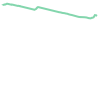

In [107]:
merged

In [81]:
# Convert bikedata2 into a geodataframe.
bike_data2_gdf = gpd.GeoDataFrame(bike_data2, geometry='geometry')

<AxesSubplot: >

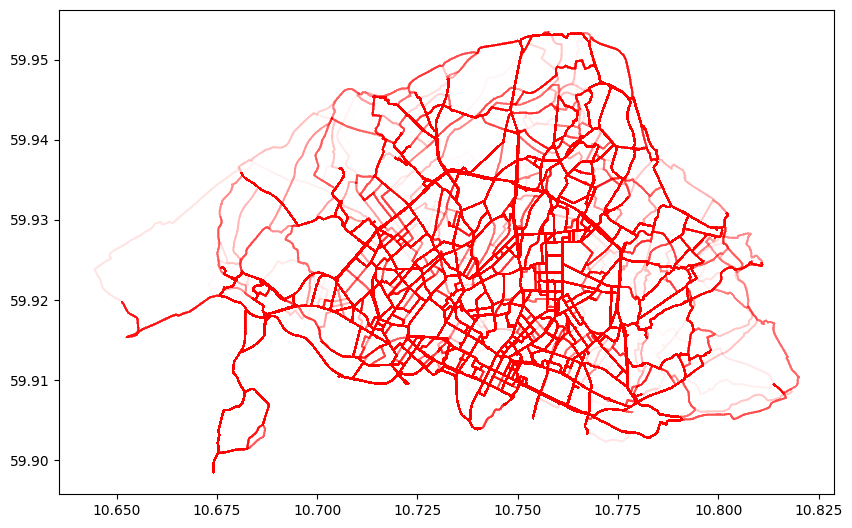

In [96]:
bike_data2_gdf.plot(figsize=(10,10), color='red', alpha=0.01)

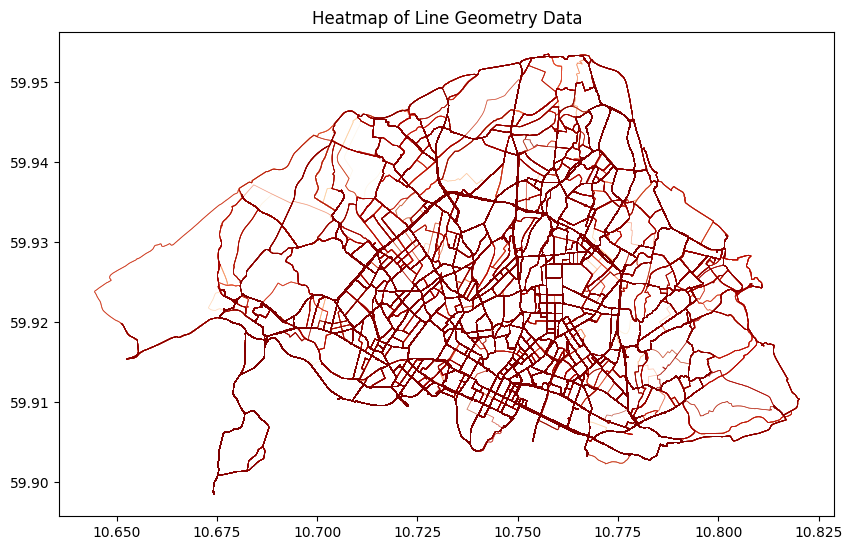

In [90]:
import matplotlib.pyplot as plt

# Create heatmap using density_kwds
ax = bike_data2_gdf.plot(cmap='OrRd', linewidth=0.5, alpha=0.5, figsize=(10,10),
               scheme='quantiles', legend=True, legend_kwds={'title': 'Value'})
ax.set_title('Heatmap of Line Geometry Data')
plt.show()

In [89]:
bike_data2_gdf.iloc[0]

started_at                     2022-07-01 03:00:14.428000+00:00
ended_at                       2022-07-01 03:16:28.492000+00:00
duration                                                    974
st_st_id                                                    447
st_st_name                                          Kværnerbyen
st_st_desc                                  langs Smeltedigelen
st_st_lat                                             59.904473
st_st_lon                                             10.786167
en_st_id                                                   1755
en_st_name                                          Aker Brygge
en_st_desc                                      ved trikkestopp
en_st_lat                                             59.911184
en_st_lon                                             10.730035
minutes                                                      16
id                                                            0
total_dist                              

**NOT WORKING**

In [86]:
import folium
from folium.plugins import HeatMap

# assume `gdf` is your GeoDataFrame with line geometry data

# convert the line geometry data to points
points = []
for line in bike_data2_gdf.geometry:
    for point in line.coords:
        points.append([point[1], point[0]])

# create a heatmap layer with the points
heatmap = HeatMap(data=points, radius=10)

# create a folium map centered on the data
m = folium.Map(location=[bike_data2_gdf.geometry.centroid.y, bike_data2_gdf.geometry.centroid.x], zoom_start=12)

# add the heatmap layer to the map
heatmap.add_to(m)

# display the map
m


/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_1446/3170334364.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[bike_data2_gdf.geometry.centroid.y, bike_data2_gdf.geometry.centroid.x], zoom_start=12)
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_1446/3170334364.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[bike_data2_gdf.geometry.centroid.y, bike_data2_gdf.geometry.centroid.x], zoom_start=12)


ValueError: Location should consist of two numerical values, but 0         59.907298
1         59.922784
2         59.911121
3         59.915830
4         59.906733
            ...    
131697    59.916639
131698    59.926302
131699    59.921866
131700    59.917547
131701    59.940489
Length: 114925, dtype: float64 of type <class 'pandas.core.series.Series'> is not convertible to float.